In [6]:
import numpy as np
import matplotlib.pyplot as plt
import brainpy.math as bm
from Network_Multiple_Maps_jzh import Place_net, Grid_net

In [7]:
z_min = 0
z_max = 20
place_num = 800
grid_num = 60
module_num = 7
map_num = 10
a_p = 0.5
Spacing = np.linspace(6,20,module_num)

Place_cell = Place_net(z_min=z_min, z_max=z_max, map_num=map_num, neuron_num=place_num, place_num=place_num, noise_stre=0.5)
maps = bm.as_numpy(Place_cell.map) 
place_index = bm.as_numpy(Place_cell.place_index) 


Gird_module_list = bm.NodeList([])
for module in range(module_num):
    Grid_cell = Grid_net(L = Spacing[module], maps=maps, place_index=place_index, neuron_num=grid_num, J0=5, a_g=a_p/Spacing[module]*2*bm.pi)
    Gird_module_list.append(Grid_cell)

conn_out = Grid_cell.conn_out

  0%|          | 0/5000 [00:00<?, ?it/s]

2
0.6683487977300371


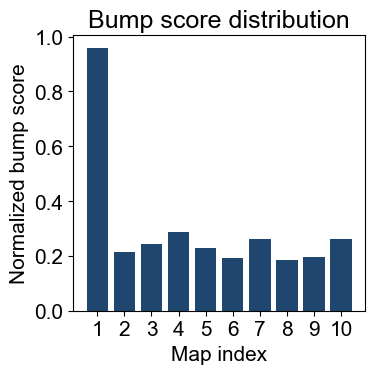

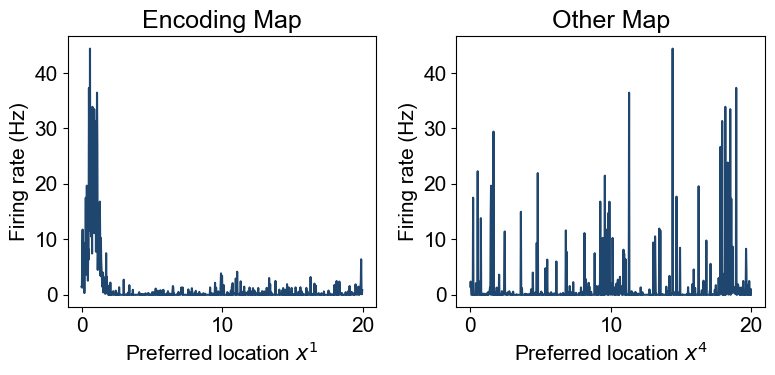

In [10]:
z0 = 0
map_index = 0
I_per = 1.
def initialize(indices, input_stre):
    r_hpc = Place_cell.r
    output = bm.zeros(place_num,)
    for Grid_cell in Gird_module_list:
        Grid_cell.step_run(indices, r_hpc= r_hpc, loc=z0, input_stre=input_stre, map_index = map_index, )
        output += Grid_cell.output
    Place_cell.step_run(indices, loc=z0, map_index = map_index, input_stre=input_stre, input_g = I_per*output)
    place_r = Place_cell.r
        # output = bm.where(output>0, output, 0)
    return output, place_r


total_time = 5000
start_time = 1000
indices = bm.arange(total_time)
loc = bm.zeros(total_time) + (z_max+z_min)/2
input_stre = bm.zeros(total_time) 
input_stre[:start_time] = 10.
output, place_r = bm.for_loop(initialize, (indices, input_stre), progress_bar = True)

u = Place_cell.r
loc_num = 100
loc_candidate = np.linspace(z_min,z_max,loc_num,endpoint=False)
bump_score = np.zeros(map_num,)
max_score_pos = np.zeros(map_num,)
for map_index in range(map_num):
    u_place = bm.as_numpy(u[place_index[map_index]])
    score_candidate = np.zeros(loc_num,)
    for j in range(loc_num):
        bump = Place_cell.get_bump(map_index, loc_candidate[j])
        u_place = u_place/bm.sum(u_place)
        score_candidate[j] = bm.sum(bump*u_place)
        bump_score[map_index] = np.max(score_candidate)
    max_score_pos[map_index] = loc_candidate[np.argmax(score_candidate)]

plt.rcParams.update({'font.size': 15, 'font.family': 'Arial'})
bump_score = bump_score/0.7

plt.figure(figsize=(4,4))
plt.bar(np.arange(map_num)+1, bump_score, color=[30/255, 70/255, 110/255])
plt.xticks(np.arange(map_num)+1)
plt.xlabel('Map index')
plt.ylabel('Normalized bump score')
plt.title('Bump score distribution')
plt.tight_layout()
plt.savefig('./figures/bump_score.pdf')

plt.rcParams.update({'font.size': 15, 'font.family': 'Arial'})


bump_score_other = bump_score[1:]
index = np.argmax(bump_score_other)
print(index)
print(bump_score[0]-bump_score_other[index])
# 绘图
_, ax = plt.subplots(1, 2, figsize=(2*4, 4))
for map_index in range(2):
    if map_index == 1:
        u_place = place_r[:, place_index[index+1]]
        sorted_indices = np.argsort(maps[index+1])
        sorted_maps = maps[index+1, sorted_indices]
        sorted_u_place = u_place[:, sorted_indices]
        ax[map_index].plot(sorted_maps, sorted_u_place[-1, :]*1000, color=[30/255, 70/255, 110/255])
        ax[map_index].set_title(f'Other Map')
        ax[map_index].set_xlabel(r'Preferred location $x^{' + str(index+1+1) + '}$')
        ax[map_index].set_ylabel('Firing rate (Hz)')
    else:
        u_place = place_r[:, place_index[map_index]]
        sorted_indices = np.argsort(maps[map_index])
        sorted_maps = maps[map_index, sorted_indices]
        sorted_u_place = u_place[:, sorted_indices]
        ax[map_index].plot(sorted_maps, sorted_u_place[-1, :]*1000, color=[30/255, 70/255, 110/255])
        ax[map_index].set_title(f'Encoding Map')
        ax[map_index].set_xlabel(r'Preferred location $x^{' + str(map_index+1) + '}$')
        ax[map_index].set_ylabel('Firing rate (Hz)')
plt.tight_layout()
plt.savefig('figures/Bump_states.pdf')


In [14]:

map_index = 0
timestep = 100 #总共移动的次数
L_env = 20 #环境总长度
dz = L_env/timestep #每次移动的步长
r_place_record = bm.zeros((timestep, place_num))
phi_record = bm.zeros((timestep, module_num))
# v 是一个timestep*5000的向量，每隔5000个index， v = 20/timestep, 其他地方v=0
z = np.arange(timestep)*dz
phi_hist = [Grid_cell.center[0] for Grid_cell in Gird_module_list]
delta_z = L_env/timestep

def Path_integration(integrate_step):
    phi_grid = bm.zeros(module_num)
    # path_integration
    for index, Grid_cell in enumerate(Gird_module_list):
        phi_grid[index] = Grid_cell.center[0] + delta_z/Grid_cell.L*bm.pi*2
        phi_grid[index] = bm.where(phi_grid[index]>bm.pi, phi_grid[index]-bm.pi*2, phi_grid[index])
        phi_grid[index] = bm.where(phi_grid[index]<-bm.pi, phi_grid[index]+bm.pi*2, phi_grid[index])

    def single_step(indices, input_stre):
        r_hpc = bm.zeros(place_num,)
        output = bm.zeros(place_num,)
        for index in range(module_num):
            Grid_cell = Gird_module_list[index]
            Grid_cell.update_phi(r_hpc = r_hpc, phase_input=phi_grid[index], input_stre=input_stre)
            output += Grid_cell.output

        Place_cell.update_phi(map_index = map_index, input_g = I_per*output)
        place_r = Place_cell.r
        return place_r


    total_time = 2000
    input_stre = bm.zeros(total_time) 
    input_stre[:start_time] = 10.
    indices = bm.arange(total_time)

    place_r = bm.for_loop(single_step, (indices, input_stre), progress_bar = False)
    record_place_r = place_r[-1]
    return phi_grid, record_place_r

integrate_step = bm.arange(timestep)
record_phi, record_place_r = bm.for_loop(Path_integration, (integrate_step), progress_bar = True)



  0%|          | 0/100 [00:00<?, ?it/s]

(100, 7)


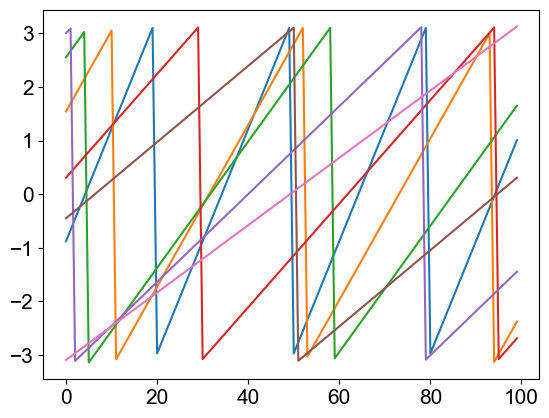

In [15]:
# plt.plot(z)
print(record_phi.shape)
plt.plot(record_phi)

/var/folders/cc/s0ls8jsx21n4zc1_dv62hvyc0000gn/T/ipykernel_82794/1091666362.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(z,np.arange(place_num),flipped_sorted_u_place_couple)


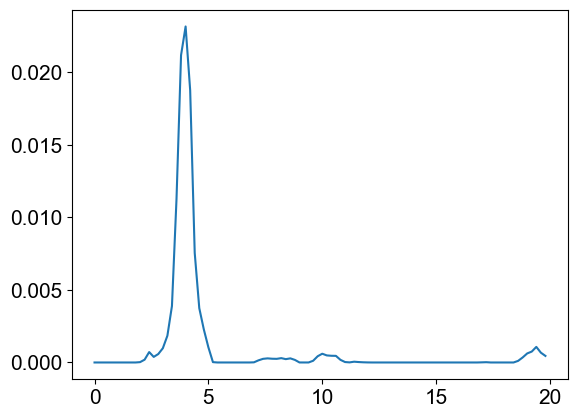

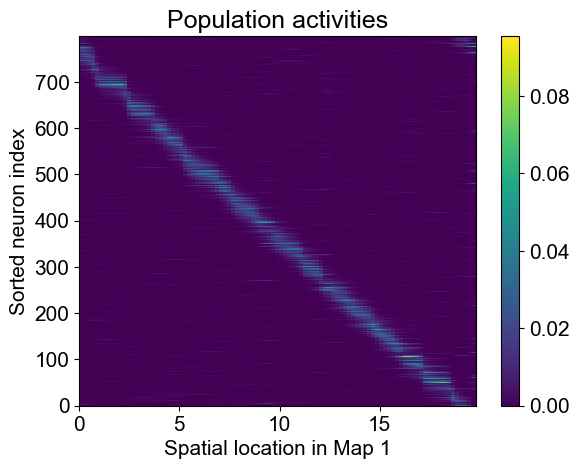

In [17]:


map_index = 0
u_place_couple = record_place_r[:, place_index[map_index]]
sorted_indices = np.argsort(maps[map_index])
sorted_maps = maps[map_index, sorted_indices]

sorted_u_place_couple = u_place_couple[:, sorted_indices]
plt.plot(z,sorted_u_place_couple[:,200])

# Flip the sorted_u_place matrix upside down
flipped_sorted_u_place_couple = np.flipud(sorted_u_place_couple.T)
plt.figure()
plt.pcolormesh(z,np.arange(place_num),flipped_sorted_u_place_couple)
plt.colorbar()  # Optional: Add a color bar for reference
plt.xlabel('Spatial location in Map 1')  # Optional: Add X axis label
plt.ylabel('Sorted neuron index')  # Optional: Add Y axis label
plt.title('Population activities')  # Optional: Add title
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

5


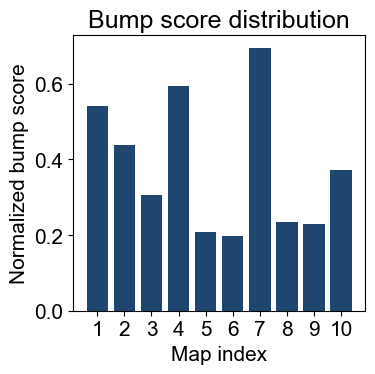

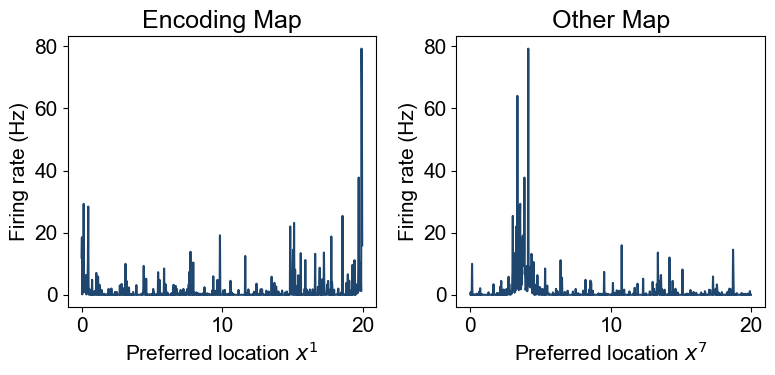

In [18]:
### Only place cells
z0 = 0
map_index = 0
I_per = 0.
def initialize(indices, input_stre):
    r_hpc = Place_cell.r
    output = bm.zeros(place_num,)
    for Grid_cell in Gird_module_list:
        Grid_cell.step_run(indices, r_hpc= r_hpc, loc=z0, input_stre=input_stre, map_index = map_index, )
        output += Grid_cell.output
    Place_cell.step_run(indices, loc=z0, map_index = map_index, input_stre=input_stre, input_g = I_per*output)
    place_r = Place_cell.r
        # output = bm.where(output>0, output, 0)
    return output, place_r


total_time = 5000
start_time = 1000
indices = bm.arange(total_time)
loc = bm.zeros(total_time) + (z_max+z_min)/2
input_stre = bm.zeros(total_time) 
input_stre[:start_time] = 10.
output, place_r = bm.for_loop(initialize, (indices, input_stre), progress_bar = True)

u = Place_cell.r
loc_num = 100
loc_candidate = np.linspace(z_min,z_max,loc_num,endpoint=False)
bump_score = np.zeros(map_num,)
max_score_pos = np.zeros(map_num,)
for map_index in range(map_num):
    u_place = bm.as_numpy(u[place_index[map_index]])
    score_candidate = np.zeros(loc_num,)
    for j in range(loc_num):
        bump = Place_cell.get_bump(map_index, loc_candidate[j])
        u_place = u_place/bm.sum(u_place)
        score_candidate[j] = bm.sum(bump*u_place)
    if map_index == 0:
        bump_score[map_index] = np.max(score_candidate)
    else:
        bump_score[map_index] = np.max(score_candidate)
    max_score_pos[map_index] = loc_candidate[np.argmax(score_candidate)]

plt.rcParams.update({'font.size': 15, 'font.family': 'Arial'})
bump_score = bump_score/0.7

plt.figure(figsize=(4,4))
plt.bar(np.arange(map_num)+1, bump_score, color=[30/255, 70/255, 110/255])
plt.xticks(np.arange(map_num)+1)
plt.xlabel('Map index')
plt.ylabel('Normalized bump score')
plt.title('Bump score distribution')
plt.tight_layout()

plt.rcParams.update({'font.size': 15, 'font.family': 'Arial'})


bump_score_other = bump_score[1:]
index = np.argmax(bump_score_other)
print(index)
# 绘图
_, ax = plt.subplots(1, 2, figsize=(2*4, 4))
for map_index in range(2):
    if map_index == 1:
        u_place = place_r[:, place_index[index+1]]
        sorted_indices = np.argsort(maps[index+1])
        sorted_maps = maps[index+1, sorted_indices]
        sorted_u_place = u_place[:, sorted_indices]
        ax[map_index].plot(sorted_maps, sorted_u_place[-1, :]*1000, color=[30/255, 70/255, 110/255])
        ax[map_index].set_title(f'Other Map')
        ax[map_index].set_xlabel(r'Preferred location $x^{' + str(index+1+1) + '}$')
        ax[map_index].set_ylabel('Firing rate (Hz)')
    else:
        u_place = place_r[:, place_index[map_index]]
        sorted_indices = np.argsort(maps[map_index])
        sorted_maps = maps[map_index, sorted_indices]
        sorted_u_place = u_place[:, sorted_indices]
        ax[map_index].plot(sorted_maps, sorted_u_place[-1, :]*1000, color=[30/255, 70/255, 110/255])
        ax[map_index].set_title(f'Encoding Map')
        ax[map_index].set_xlabel(r'Preferred location $x^{' + str(map_index+1) + '}$')
        ax[map_index].set_ylabel('Firing rate (Hz)')
plt.tight_layout()



In [19]:

map_index = 0
I_per = 1.
timestep = 100 #总共移动的次数
L_env = 20 #环境总长度
dz = L_env/timestep #每次移动的步长
r_place_record = bm.zeros((timestep, place_num))
phi_record = bm.zeros((timestep, module_num))
# v 是一个timestep*5000的向量，每隔5000个index， v = 20/timestep, 其他地方v=0
z = np.arange(timestep)*dz
phi_hist = [Grid_cell.center[0] for Grid_cell in Gird_module_list]
delta_z = L_env/timestep

def Path_integration(integrate_step):
    phi_grid = bm.zeros(module_num)
    # path_integration
    for index, Grid_cell in enumerate(Gird_module_list):
        phi_grid[index] = Grid_cell.center[0] + delta_z/Grid_cell.L*bm.pi*2
        phi_grid[index] = bm.where(phi_grid[index]>bm.pi, phi_grid[index]-bm.pi*2, phi_grid[index])
        phi_grid[index] = bm.where(phi_grid[index]<-bm.pi, phi_grid[index]+bm.pi*2, phi_grid[index])

    def single_step(indices, input_stre):
        r_hpc = bm.zeros(place_num,)
        output = bm.zeros(place_num,)
        for index in range(module_num):
            Grid_cell = Gird_module_list[index]
            Grid_cell.update_phi(r_hpc = r_hpc, phase_input=phi_grid[index], input_stre=input_stre)
            output += Grid_cell.output

        Place_cell.update_phi(map_index = map_index, input_g = I_per*output)
        place_r = Place_cell.r
        return place_r


    total_time = 2000
    input_stre = bm.zeros(total_time) 
    input_stre[:start_time] = 10.
    indices = bm.arange(total_time)

    place_r = bm.for_loop(single_step, (indices, input_stre), progress_bar = False)
    record_place_r = place_r[-1]
    return phi_grid, record_place_r

integrate_step = bm.arange(timestep)
record_phi, record_place_r = bm.for_loop(Path_integration, (integrate_step), progress_bar = True)



  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/cc/s0ls8jsx21n4zc1_dv62hvyc0000gn/T/ipykernel_82794/940668125.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(z,np.arange(place_num),flipped_sorted_u_place)


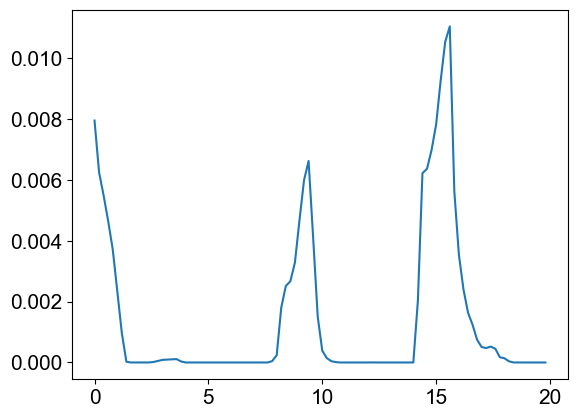

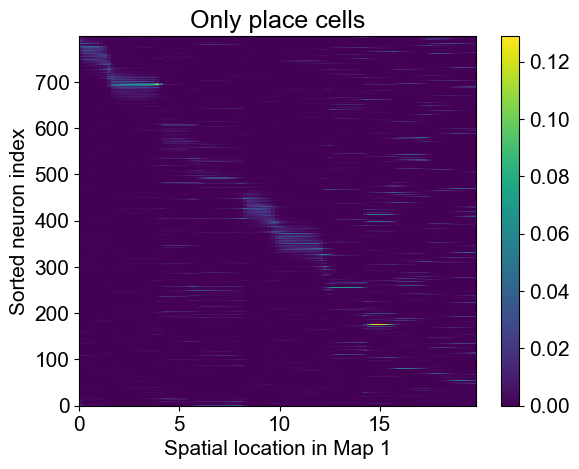

In [20]:
map_index = 0
u_place = record_place_r[:, place_index[map_index]]
sorted_indices = np.argsort(maps[map_index])
sorted_maps = maps[map_index, sorted_indices]
sorted_u_place = u_place[:, sorted_indices]
# Flip the sorted_u_place matrix upside down
flipped_sorted_u_place = np.flipud(sorted_u_place.T)
plt.plot(z,sorted_u_place[:,10])
plt.figure()
plt.pcolormesh(z,np.arange(place_num),flipped_sorted_u_place)
plt.colorbar()  # Optional: Add a color bar for reference
plt.xlabel('Spatial location in Map 1')  # Optional: Add X axis label
plt.ylabel('Sorted neuron index')  # Optional: Add Y axis label
plt.title('Only place cells')  # Optional: Add title
plt.show()

/var/folders/cc/s0ls8jsx21n4zc1_dv62hvyc0000gn/T/ipykernel_82794/3106414223.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax0 = ax[0].pcolormesh(z, np.arange(place_num), flipped_sorted_u_place_couple, cmap='hot')
/var/folders/cc/s0ls8jsx21n4zc1_dv62hvyc0000gn/T/ipykernel_82794/3106414223.py:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax1 = ax[1].pcolormesh(z, np.arange(place_num), flipped_sorted_u_place, cmap='hot')


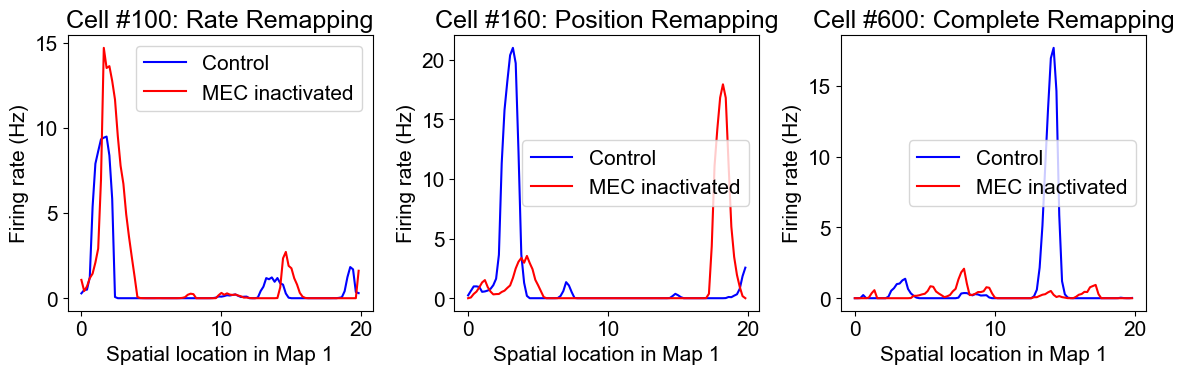

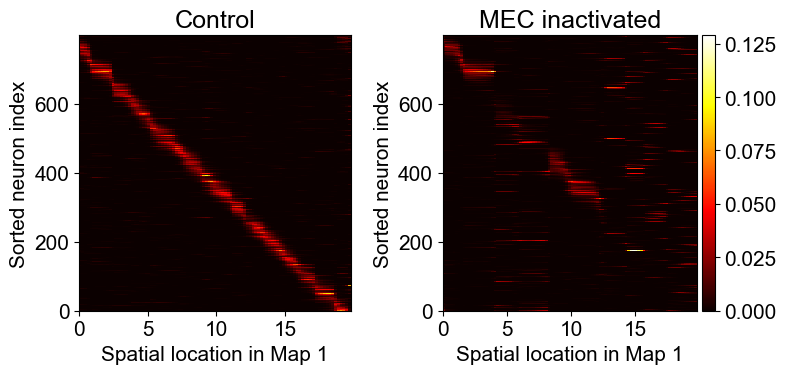

In [53]:
neuron_index = np.array([100,160,600])

plt.rcParams.update({'font.size': 15, 'font.family': 'Arial'})
fig, ax = plt.subplots(1, 3, figsize=(3*4, 4))
for i in range(3):
    ax[i].plot(z, sorted_u_place_couple[:, neuron_index[i]] * 1000, color='b', label='Control')
    ax[i].plot(z, sorted_u_place[:, neuron_index[i]] * 1000, color='r', label='MEC inactivated')
    ax[i].set_xlabel('Spatial location in Map 1')  # Optional: Add X axis label
    ax[i].set_ylabel('Firing rate (Hz)')
    ax[i].legend(loc='best')  # Add legend to each subplot with optimal location

ax[0].set_title('Cell #100: Rate Remapping')
ax[1].set_title('Cell #160: Position Remapping')
ax[2].set_title('Cell #600: Complete Remapping')
plt.tight_layout()
plt.savefig('Remapping_single_cell.pdf')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first pcolormesh
cax0 = ax[0].pcolormesh(z, np.arange(place_num), flipped_sorted_u_place_couple, cmap='hot')
ax[0].set_xlabel('Spatial location in Map 1')
ax[0].set_ylabel('Sorted neuron index')
ax[0].set_title('Control')

# Plot the second pcolormesh
cax1 = ax[1].pcolormesh(z, np.arange(place_num), flipped_sorted_u_place, cmap='hot')
ax[1].set_xlabel('Spatial location in Map 1')
ax[1].set_ylabel('Sorted neuron index')
ax[1].set_title('MEC inactivated')

# Create colorbar
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(cax1, cax=cax)

plt.tight_layout()
plt.savefig('Remapping_population.pdf')
plt.show()




(array([69., 23., 21., 18., 10., 10.,  9., 11.,  9.,  5., 10., 10.,  4.,
         9.,  9.,  4., 10.,  6.,  5.,  3., 10., 10.,  6.,  7.,  5.,  7.,
         3.,  1.,  6.,  4.,  3.,  3.,  5.,  5.,  3.,  5.,  6.,  5.,  2.,
         1.,  6.,  6.,  2., 11.,  4., 11.,  5.,  3.,  2.,  4.,  8.,  7.,
         7.,  6.,  6.,  7.,  2.,  3.,  3.,  3.,  4.,  3.,  4.,  3.,  5.,
         5.,  3.,  1.,  5.,  2.,  6.,  3.,  4.,  1.,  4.,  5.,  4.,  4.,
         4.,  2.,  1.,  4.,  1.,  2.,  3.,  4.,  5.,  3.,  3.,  9.,  6.,
         4.,  3.,  5.,  4.,  7.,  4.,  4.,  5.,  3.,  4.,  4.,  8.,  3.,
         3.,  2.,  4.,  3.,  1.,  0.,  3.,  6.,  6.,  4.,  2.,  7.,  5.,
         4.,  2.,  2.,  0.,  1.,  9.,  4.,  2.,  4.,  2.,  0.,  2.,  4.,
         1.,  2.,  3.,  4.,  1.,  3.,  4.,  1.,  5.,  4.,  4.,  4.,  0.,
         0.,  2.,  3.,  2.,  1.,  2.,  3.,  0.,  2.,  2.,  4.,  0.,  0.,
         2.,  3.,  2.,  3.,  2.,  0.,  1.,  0.,  2.,  2.,  0.,  2.,  0.,
         1.,  2.,  2.,  2.,  0.,  2.,  0.,  1.,  1.

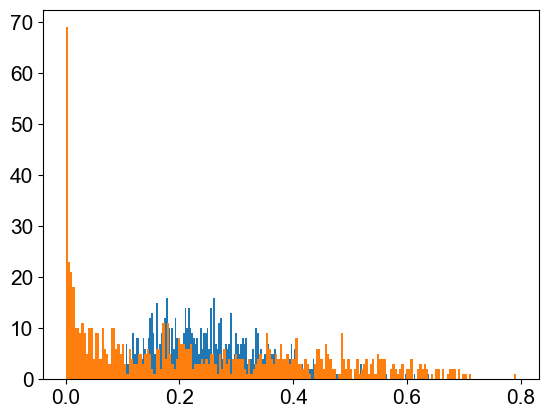

In [62]:

np.savez('Remapping_population_activity.npz',
         sorted_u_place_couple=sorted_u_place_couple,
         sorted_u_place=sorted_u_place)


721


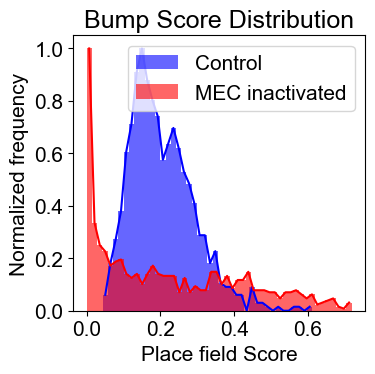

In [82]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15, 'font.family': 'Arial'})
# 定义距离函数
def dist(a, b, L):
    dis = np.abs(a - b)
    dis = np.where(dis < L / 2, dis, L - dis)
    return dis

# 计算bump score
def bump_score(sorted_u_place):
    # loc_space = np.linspace(0, 20, timestep)
    place_cell_feature = np.linspace(0, 20, place_num)
    scores = np.zeros(place_num)
    for loc_j in range(place_num):
        loc_neuron = place_cell_feature[loc_j]
        dis = dist(loc_neuron, z, 20)
        bump = np.exp(-dis**2 / (2 * a_p**2))
        u_place = sorted_u_place[:, loc_j]
        u_place = u_place / np.sum(u_place)
        scores[loc_j] = np.sum(bump * u_place)
    return scores

# 计算 scores
scores_only = bump_score(sorted_u_place)
scores_couple = bump_score(sorted_u_place_couple)
print(np.argmax(scores_only))

# 计算 scores_couple 的直方图
counts_couple, bins_couple = np.histogram(scores_couple, bins=40)
counts_couple = counts_couple / np.max(counts_couple)  # 归一化
bin_centers_couple = (bins_couple[:-1] + bins_couple[1:]) / 2

# 计算 scores_only 的直方图
counts_only, bins_only = np.histogram(scores_only, bins=50)
counts_only = counts_only / np.max(counts_only)  # 归一化
bin_centers_only = (bins_only[:-1] + bins_only[1:]) / 2

# 绘制直方图及包络线
plt.figure(figsize=(4,4))
plt.bar(bin_centers_couple, counts_couple, width=bin_centers_couple[1] - bin_centers_couple[0], alpha=0.6, color='b', label='Control')
plt.plot(bin_centers_couple, counts_couple, color='b')

plt.bar(bin_centers_only, counts_only, width=bin_centers_only[1] - bin_centers_only[0], alpha=0.6, color='r', label='MEC inactivated')
plt.plot(bin_centers_only, counts_only, color='r')

# 添加标签和标题
plt.xlabel('Place field Score')
plt.ylabel('Normalized frequency')
plt.legend()
plt.title('Bump Score Distribution')

plt.tight_layout()
plt.savefig('Bump_Score_Distribution.pdf')
plt.show()


54


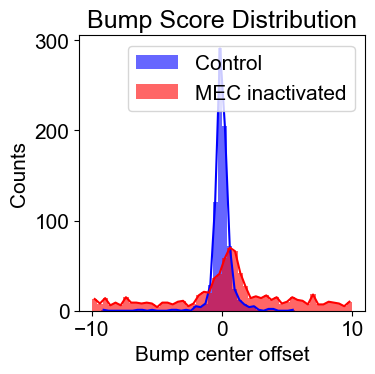

In [93]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15, 'font.family': 'Arial'})
# 定义距离函数
def dist(a, b, L):
    dis = np.abs(a - b)
    dis = np.where(dis < L / 2, dis, L - dis)
    return dis

# 计算bump score
def bump_center_offset(sorted_u_place):
    z_range = 20
    center = np.zeros(place_num)
    place_cell_feature = np.linspace(0, 20, place_num)
    for i in range(place_num):
        r = sorted_u_place[:,i]
        x = (z / z_range - 1 / 2) * 2 * np.pi
        exppos = np.exp(1j * x)
        center[i] = (np.angle(np.sum(exppos * r)) / 2 / np.pi + 1 / 2) * z_range 
    center_off = center+1 - place_cell_feature
    center_off = np.where(center_off>10, center_off-20, center_off)
    center_off = np.where(center_off<-10, center_off+20, center_off)
    return center_off

# 计算 scores
scores_only = bump_center_offset(sorted_u_place)
scores_couple = bump_center_offset(sorted_u_place_couple)
print(np.argmax(scores_only))

# 计算 scores_couple 的直方图
counts_couple, bins_couple = np.histogram(scores_couple, bins=40)
counts_couple = counts_couple  # 归一化
bin_centers_couple = (bins_couple[:-1] + bins_couple[1:]) / 2

# 计算 scores_only 的直方图
counts_only, bins_only = np.histogram(scores_only, bins=50)
counts_only = counts_only   # 归一化
bin_centers_only = (bins_only[:-1] + bins_only[1:]) / 2

# 绘制直方图及包络线
plt.figure(figsize=(4,4))
plt.bar(bin_centers_couple, counts_couple, width=bin_centers_couple[1] - bin_centers_couple[0], alpha=0.6, color='b', label='Control')
plt.plot(bin_centers_couple, counts_couple, color='b')

plt.bar(bin_centers_only, counts_only, width=bin_centers_only[1] - bin_centers_only[0], alpha=0.6, color='r', label='MEC inactivated')
plt.plot(bin_centers_only, counts_only, color='r')

# 添加标签和标题
plt.xlabel('Bump center offset')
plt.ylabel('Counts')
plt.legend()
plt.title('Bump Score Distribution')

plt.tight_layout()
plt.savefig('Center_Offset_Distribution.pdf')
plt.show()
